# ***4.* Recurrent network of nonlinear springs and masses**

## *4.1* **Implementation of the recurrent networks of non-linear springs and masses**

### *4.1.1* Constructing mass-spring networks

Importing Libraries

In [372]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import Delaunay
import random
import math
import matplotlib.cm as cm

Having a dictionary to contain all the inital setups

In [373]:
init_dict = dict()

Setting up

1.   number of nodes (N)
2.   limits of x and y coordinates



In [374]:
init_dict['nodes'] = 10 #Number of masses
init_dict['x_lim'] = [0,10]
init_dict['y_lim'] = [0,10]

Setting up the spring parameter ranges

In [375]:
init_dict['k_range'] = np.array([[100, 200], [1, 10]])
init_dict['d_range'] = np.array([[100, 200], [1, 10]])

Setting up weight parameters

In [376]:
init_dict['w_out_range'] = [-1, 1]
init_dict['w_feedback_range'] = [-1, 1]
init_dict['w_input_range'] = [-1 ,1]

Feedback parameters

In [377]:
init_dict['fb_conn'] = 0 #Feedback connectivity

Number of inputs and outputs

In [378]:
init_dict['nInput'] = 1
init_dict['input_percentage'] = 0.2 #percentage of input connectivity nodes
init_dict['nOutput'] = 1
init_dict['out_conn'] = 1 #1 = 100% of nodes

Initializing time_steps and steps to show (show_steps)

In [379]:
init_dict['time_step'] = 0.001 # time_step = 1 ms = 0.001 s
init_dict['show_steps'] = 1000 # to show the simulation progress at every 1000 steps

Also defining the readout type we want

In [380]:
init_dict['readout_type'] = 'LENGTHS'

Printing the initial dictionary we defined

In [381]:
init_dict

{'nodes': 10,
 'x_lim': [0, 10],
 'y_lim': [0, 10],
 'k_range': array([[100, 200],
        [  1,  10]]),
 'd_range': array([[100, 200],
        [  1,  10]]),
 'w_out_range': [-1, 1],
 'w_feedback_range': [-1, 1],
 'w_input_range': [-1, 1],
 'fb_conn': 0,
 'nInput': 1,
 'input_percentage': 0.2,
 'nOutput': 1,
 'out_conn': 1,
 'time_step': 0.001,
 'show_steps': 1000,
 'readout_type': 'LENGTHS'}

Setting up acceleration function ( d(x_2)/dx ) and x2

In [382]:
class x_accln:
  def __init__(self, x1,x2,k1,k3,d1,d3,u):
    self.accl = -1*(self.p(k1,k3,x1)) - self.q(d1,d3,x2) + u
  def p(k1,k3,x1):
    return k3*(x1**3) + k1*x1
  def q(d1,d3,x2):
    return d3*(x2**3) + d1*x2

Now since we have initialized the parameters, we will build up the net of spring_mass system now

So, first we define a dictionary called net, which will have our initialized data and also the informations about the points.

In [383]:
net = dict()

net['init_data'] = init_dict
num = init_dict['nodes']

net['P'] = dict()

Random initialization of point states and forces

In [384]:
net['P']['states'] = np.column_stack([
      np.random.uniform(init_dict['x_lim'][0], init_dict['x_lim'][1], num),
      np.random.uniform(init_dict['y_lim'][0], init_dict['y_lim'][1], num),
      np.zeros(num),
      np.zeros(num)
  ])
net['P']['force'] = np.zeros((num, 2)) #The forces with Fx and Fy
net['P']['fixed'] = np.zeros(num) # 0 if the nodes are not fixed, and we update it to 1 if they are fixed

Saving initial position and velocities of P

In [385]:
net['init_data']['P'] = net['P']

Fixing the leftmost and rightmost point such that our net remains stable

In [386]:
#Finding the rightmost (argmax) and leftmost (argmin) points

min_idx = np.argmin(net['P']['states'][:, 0])
max_idx = np.argmax(net['P']['states'][:, 0])

#Putting 1 at the points position, representing that it is fixed

net['P']['fixed'][min_idx] = 1
net['P']['fixed'][max_idx] = 1

Since, we have the points (nodes) now, so, we have to do **Delaunay triangulation** such that no two spring connections should overlap each other.

In [387]:
tri = Delaunay(net['P']['states'][:, :2])
net['init_data']['tri'] = tri

Sorting the triangulation is used to ensure that the triangles are processed in a specific order. Specifically, the np.sort function sorts the simplices (i.e., the triangles) in the triangulation along the second dimension, which corresponds to the nodes of each simplex.
This is necessary to ensure that the connections between adjacent triangles are processed correctly in the subsequent code.

In [388]:
tri_s = np.sort(tri.simplices, axis=1)  #sorting the triangulation (Delaunay  matrix)

Making an array to put which node is connected to which node

In [389]:
R = np.zeros((net['init_data']['nodes'], net['init_data']['nodes'])) #shape  = (nodes,nodes), for N = 10 shape = (10,10)

In [390]:
for i in range(tri.simplices.shape[0]):

    # Putting connection between element 1 --> 2
    from_ = tri_s[i, 0]
    to_ = tri_s[i, 1]
    R[from_, to_] = 1

    # Putting connection between element 2 --> 3
    from_ = tri_s[i, 1]
    to_ = tri_s[i, 2]
    R[from_, to_] = 1

    # Putting connection between element 1 --> 3
    from_ = tri_s[i, 0]
    to_ = tri_s[i, 2]
    R[from_, to_] = 1

Now, we will choose the spring constants and damping constant from an exponential distribution, so we need to define a function that does that

In [391]:
def random_exp(range_,a=None):
  #a : int or array-like, optional :The size of the output array. If not provided, returns a single random value.

  lo, up = range_[0], range_[1]
  if a is None:
    n = (up - lo)*random.random() + lo
  else:
        if len(range_) == 2:
            lo, up = np.log10(lo), np.log10(up)
        n = np.power(10, (up-lo)*np.random.sample(size=a) + lo)
  return n

In [392]:
w_num = int(np.sum(R))

In [393]:
net['W'] = dict()
net['W']['from'] = np.zeros(w_num)
net['W']['to'] = np.zeros(w_num)

In [394]:
net['W']['k1'] = random_exp([init_dict['k_range'][0, 0], init_dict['k_range'][0, 1]], w_num)
net['W']['k3'] = random_exp([init_dict['k_range'][1, 0], init_dict['k_range'][1, 1]], w_num)
net['W']['d1'] = random_exp([init_dict['d_range'][0, 0], init_dict['d_range'][0, 1]], w_num)
net['W']['d3'] = random_exp([init_dict['d_range'][1, 0], init_dict['d_range'][1, 1]], w_num)

Defining the lo and old distance arrays

In [395]:
net['W']['l0'] = np.zeros(w_num) #same size as number of connections
net['W']['dist_old'] = np.zeros(w_num) #same size as number of connections

So, we go for each node number say a1, and check if there is a connection with other node say a2. If exist, then put a1 in from and a2 in to, and calculate eucledian distance between them. For that we have to define eucledian distance function

In [396]:
def e_distance(p1, p2):
    d = np.sqrt((p2[0] - p1[0]) ** 2 + (p2[1] - p1[1]) ** 2)

    if d == 0:
       norm_dir = np.zeros_like(p1)
    else:
        norm_dir = (p2 - p1) / d

    return d, norm_dir

Now, we go onto define the weights of inputs

In [397]:
w_idx = 0
for i in range(init_dict['nodes']):
    for j in range(init_dict['nodes']):
        if R[i, j] == 1:
            net['W']['from'][w_idx] = i
            net['W']['to'][w_idx] = j
            p1 =net['P']['states'][i, :2]
            p2 =net['P']['states'][j,:2]
            net['W']['l0'][w_idx] = e_distance(p1,p2)[0]
            w_idx += 1

net['W']['dist_old'][:] = net['W']['l0'][:]

Now we go onto define the input connections

In [398]:
net['W_in'] = np.zeros((init_dict['nodes'], init_dict['nInput']))
nmax = int(init_dict['nodes'] * init_dict['nInput'])

for nI in range(d['nInput']):
    Idx = np.random.permutation(init_dict['nodes'])[:nmax]
    net['W_in'][Idx, nI] = np.random.uniform(init_dict['w_input_range'][0], init_dict['w_input_range'][1], nmax)

Check for input vs. fixed points

In [406]:
for i in range(init_dict['nodes']):
    if net['P']['fixed'][i] == 1:
        net['W_in'][i, 0] = 0

Now, there may exist a feedback in the system, so we may also define weights for that.

In [400]:
net['W_fb'] = np.zeros((init_dict['nodes'], init_dict['nOutput']))
nmax = int(np.ceil(init_dict['nodes'] * init_dict['fb_conn']))

for nI in range(init_dict['nOutput']):
    Idx = np.random.permutation(init_dict['nodes'])
    Idx = Idx[:nmax]
    net['W_fb'][Idx, nI] = np.random.uniform(init_dict['w_feedback_range'][0], init_dict['w_feedback_range'][1], nmax)

So, now we further proceed to define the output system

First we define a function used to get random number in range

In [401]:
def rand_in_range(range_val, a=None):
    """
    Returns random values within a given range.

    Args:
    range_val (list): [lower, upper] bound
    a (int, optional): Either a scalar or vector with the needed size

    Returns:
    float or numpy.ndarray: Either one random value or a column vector of random values with size a
    """
    up = range_val[1]
    lo = range_val[0]

    if a is None:
        n = (up-lo)*np.random.random_sample + lo
    else:
        n = (up-lo)*np.random.random_sample(size=a)+lo
    return n

Now the readout type could be Positions or the lengths, we define it for both

In [402]:
if init_dict['readout_type'] == 'POSITIONS':
    net['W_out'] = np.zeros((init_dict['nodes'], init_dict['nOutput']))
    nmax = int(np.ceil(init_dict['nodes'] * init_dict['out_conn']))
    for nO in range(init_dict['nOutput']):
        Odx = np.random.permutation(init_dict['nodes'])
        Odx = Odx[:nmax]
        net['W_out'][Odx, nO] = rand_in_range(init_dict['w_out_range'], a=nmax)

elif init_dict['readout_type'] == 'LENGTHS':
    w_num = len(net['W']['l0'])
    net['W_out'] = np.zeros((w_num, init_dict['nOutput']))
    nmax = int(np.ceil(w_num * init_dict['out_conn']))

    for nO in range(init_dict['nOutput']):
        Odx = np.random.permutation(w_num)
        Odx = Odx[:nmax]
        net['W_out'][Odx, nO] = rand_in_range(init_dict['w_out_range'], a=nmax)

else:
    print('ERROR - unknown output chosen')

net['readout_type'] = init_dict['readout_type']

Now, let us put the indices of fixed points, input nodes and output nodes in net dictionary

In [411]:
net['fixed_idx'] = np.where(net['P']['fixed'] == 1)[0]
net['input_idx'] = np.where(np.sum(net['W_in'], axis=1) != 0)[0]
net['output_idx'] = np.where(np.sum(net['W_out'], axis=1) != 0)[0]


In [408]:
net

{'init_data': {'nodes': 10,
  'x_lim': [0, 10],
  'y_lim': [0, 10],
  'k_range': array([[100, 200],
         [  1,  10]]),
  'd_range': array([[100, 200],
         [  1,  10]]),
  'w_out_range': [-1, 1],
  'w_feedback_range': [-1, 1],
  'w_input_range': [-1, 1],
  'fb_conn': 0,
  'nInput': 1,
  'input_percentage': 0.2,
  'nOutput': 1,
  'out_conn': 1,
  'time_step': 0.001,
  'show_steps': 1000,
  'readout_type': 'LENGTHS',
  'P': {'states': array([[3.12396054, 5.9345055 , 0.        , 0.        ],
          [2.13624593, 9.62547778, 0.        , 0.        ],
          [9.34820893, 3.56863815, 0.        , 0.        ],
          [7.77310077, 2.35846493, 0.        , 0.        ],
          [9.13712821, 6.01094914, 0.        , 0.        ],
          [2.98770515, 8.48692137, 0.        , 0.        ],
          [3.05157295, 7.14529106, 0.        , 0.        ],
          [4.35138145, 8.49331975, 0.        , 0.        ],
          [8.18903101, 1.09617614, 0.        , 0.        ],
          [6.13667

Now let us plot the graph

<ipython-input-414-4770fd2c441e>:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('jet')


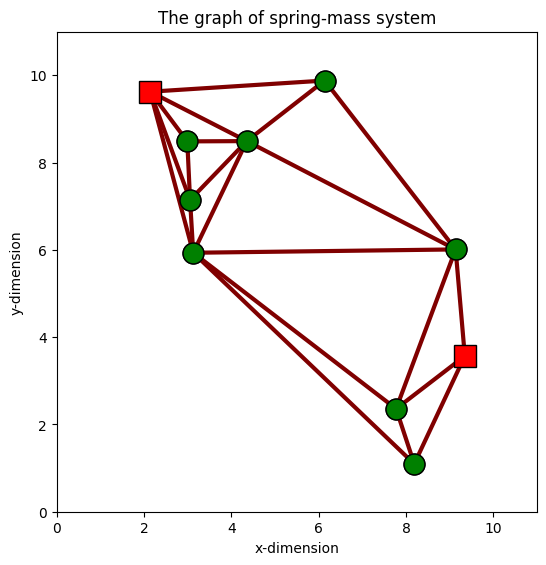

In [414]:
MARKERSIZE = 15
LINEWIDTH = 1
colored = True

fig, ax = plt.subplots()
ax.set_position([0, 0, 1, 1])
ax.set_aspect('equal')

ax.plot(net['P']['states'][:, 0], net['P']['states'][:, 1], 'o',
        markerfacecolor=[1, 1, 1], markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

if colored:
    cmap = cm.get_cmap('jet')
    max_k = np.max(net['W']['k1'])
    min_k = np.min(net['W']['k1'])
    steepness = (64 - 1) / (max_k - min_k)
    offset = 1 - steepness * min_k

    for idx in range(len(net['W']['from'])):
        col = cmap(np.ceil(steepness * (net['W']['k1'][idx] + offset)))
        from_node = net['W']['from'][idx]
        to_node = net['W']['to'][idx]
        from_node , to_node = int(from_node), int(to_node)
        ax.plot([net['P']['states'][from_node, 0], net['P']['states'][to_node, 0]],
                [net['P']['states'][from_node, 1], net['P']['states'][to_node, 1]],
                color=col, linewidth=3)
else:
    px = net['P']['states'][:, 0]
    py = net['P']['states'][:, 1]
    from_node = net['W']['from']
    to_node = net['W']['to']

    for i in range(len(net['W']['from'])):
        ax.plot([px[from_node[i]], px[to_node[i]]],
                [py[from_node[i]], py[to_node[i]]], '-k', linewidth=LINEWIDTH)

    ax.plot(net['P']['states'][:, 0], net['P']['states'][:, 1], 'o',
            markerfacecolor=[1, 1, 1], markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

ax.plot(net['P']['states'][net['fixed_idx'], 0], net['P']['states'][net['fixed_idx'], 1], 's',
        markerfacecolor='r', markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE + 1)

ax.plot(net['P']['states'][net['input_idx'], 0], net['P']['states'][net['input_idx'], 1], 'o',
        markerfacecolor='g', markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

if net['readout_type'] == 'POSITIONS':
    ax.plot(net['P']['states'][net['output_idx'], 0], net['P']['states'][net['output_idx'], 1], 'om', linewidth=10)

if np.max(np.abs(net['W_fb'])) > 0 and net['W_fb'].shape[1] == 2:
    feedback_1_idx = np.setdiff1d(np.where(np.abs(net['W_fb'][:, 0]) > 0), net['fixed_idx'])
    feedback_2_idx = np.setdiff1d(np.where(np.abs(net['W_fb'][:, 1]) > 0), net['fixed_idx'])
    fb_color_1 = [0, 1, 1]
    fb_color_2 = [1, 0, 1]

    ax.plot(net['P']['states'][feedback_1_idx, 0], net['P']['states'][feedback_1_idx, 1], 'o',
            markerfacecolor=fb_color_1, markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

    ax.plot(net['P']['states'][feedback_2_idx, 0], net['P']['states'][feedback_2_idx, 1], 'o',
            markerfacecolor=fb_color_2, markeredgecolor='k', linewidth=LINEWIDTH, markersize=MARKERSIZE)

ax.set_xlim(net['init_data']['x_lim'][0] * (1 - 0.1), net['init_data']['x_lim'][1] * (1 + 0.1))
ax.set_ylim(net['init_data']['y_lim'][0] * (1 - 0.1), net['init_data']['y_lim'][1] * (1 + 0.1))

ax.set_xlabel('x-dimension')
ax.set_ylabel('y-dimension')
ax.set_title('The graph of spring-mass system')
plt.show()